# Answering Business Questions using SQL

We'll be working with a modified version of a database called Chinook. The Chinook database contains information about a fictional digital music shop - kind of like a mini-iTunes store.

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

db = 'chinook-unmodified.db'

In [2]:
# run_query() takes a SQL query as an argument and returns a pandas dataframe of that query

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)

In [3]:
# run_command() takes a SQL command as an argument and executes it using the sqlite module

def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None # tells SQLite to autocommit any changes
        conn.execute(c)

In [4]:
# show_tables() returns a list of all tables and views in the database

def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table','view');"
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Best selling music genres in the USA

In [6]:
q1 = '''
WITH tracks_sold_us AS
(
SELECT
	g.name AS genre,
	SUM(il.quantity) AS num_tracks_sold
FROM genre AS g
INNER JOIN track AS t
ON t.genre_id = g.genre_id
INNER JOIN invoice_line AS il
ON il.track_id = T.track_id
INNER JOIN invoice i
ON i.invoice_id = il.invoice_id
INNER JOIN customer AS c
ON i.customer_id = c.customer_id
WHERE c.country = "USA"
GROUP BY g.name
ORDER BY 2 DESC
)

SELECT
	genre,
	num_tracks_sold,
	100*(CAST(num_tracks_sold AS float) / (SELECT SUM(num_tracks_sold) FROM tracks_sold_us)) AS percentage_track_sold
FROM tracks_sold_us;
'''

genre_usa = run_query(q1)
genre_usa

,genre,num_tracks_sold,percentage_track_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


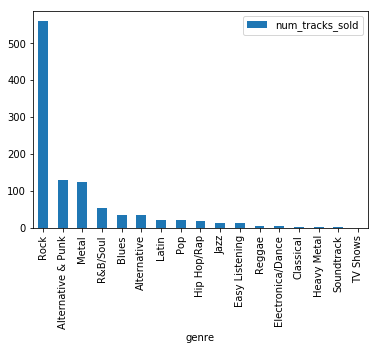

In [7]:
genre_usa[['genre', 'num_tracks_sold']].set_index('genre').plot.bar()

## Analyzing the performance of sales support agents

In [8]:
q2 = '''
SELECT 
	(e.first_name || ' ' || e.last_name) AS employee_name,
	e.hire_date,
	SUM(i.total) total_sale
FROM employee AS e
INNER JOIN customer AS c
ON c.support_rep_id = e.employee_id
INNER JOIN invoice AS i
ON i.customer_id = c.customer_id
GROUP BY 1;
'''
employee_sales = run_query(q2)
employee_sales

,employee_name,hire_date,total_sale
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


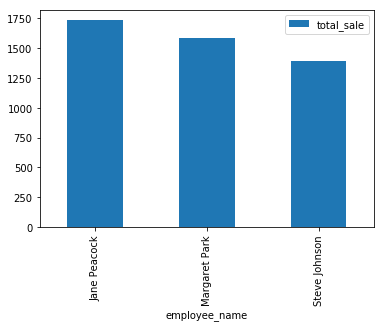

In [11]:
employee_sales[['total_sale','employee_name']].set_index('employee_name').plot.bar()

## Analyzing sales by country

In [14]:
q3 = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT COUNT(*)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i
     ON i.invoice_id = il.invoice_id
     INNER JOIN customer c 
     ON c.customer_id = i.customer_id
    )

SELECT
    country,
    total_customers,
    total_sales_value,
    mean_order_value,
    mean_customer_lifetime_value
FROM
    (
    SELECT
        country,
        count(distinct customer_id) total_customers,
        SUM(unit_price) total_sales_value,
        SUM(unit_price) / count(distinct invoice_id) mean_order_value,
        SUM(unit_price) / count(distinct customer_id) mean_customer_lifetime_value,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales_value DESC
    );  
'''

sales_by_country = run_query(q3)
sales_by_country

,country,total_customers,total_sales_value,mean_order_value,mean_customer_lifetime_value
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


## Visualizing sales by country

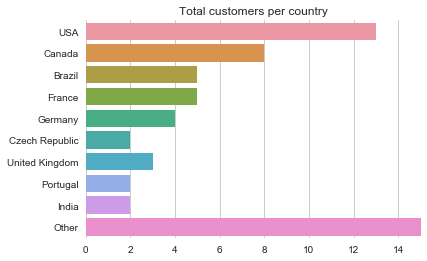

In [37]:
sns.set(style='whitegrid')
f, ax = plt.subplots()
sns.barplot(x='total_customers', y='country', data=sales_by_country, label='sales_by_country')
ax.set_title('Total customers per country')
ax.set(xlim=(0, 15), ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

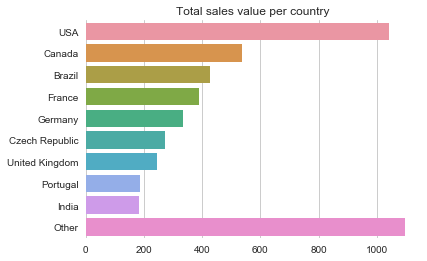

In [38]:
sns.set(style='whitegrid')
f, ax = plt.subplots()
sns.barplot(x='total_sales_value', y='country', data=sales_by_country, label='Country sales')
ax.set_title('Total sales value per country')
ax.set(ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

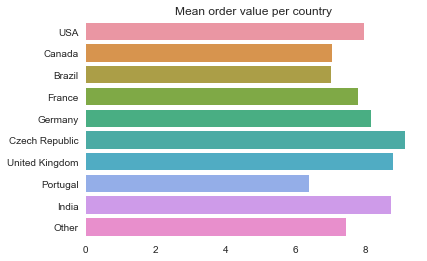

In [41]:
sns.set(style='white')
f, ax = plt.subplots()
sns.barplot(x='mean_order_value', y='country',data=sales_by_country,label='Country sales')
ax.set_title('Mean order value per country')
ax.set(ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

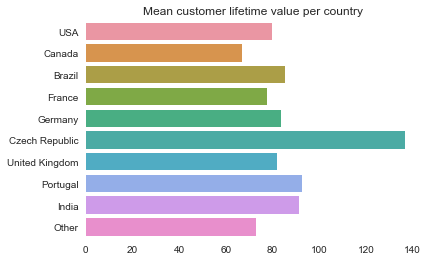

In [43]:
sns.set(style='white')
f, ax = plt.subplots()
sns.barplot(x='mean_customer_lifetime_value', y='country', data=sales_by_country, label='Country Sales')
ax.set_title('Mean customer lifetime value per country')
ax.set(ylabel='', xlabel='')
sns.despine(left=True, bottom=True)

## Album vs. individual purchuses

In [46]:
q4 = '''

WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id AS invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line AS il
     GROUP BY 1
    )

SELECT
    album_purchased,
    COUNT(invoice_id) number_of_invoices,
    CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(*) FROM invoice) percentage_of_invoices
FROM
    (
    SELECT
        ift.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t1.album_id FROM track t1
                                      WHERE t1.track_id = ift.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il1.track_id FROM invoice_line il1
                  WHERE il1.invoice_id = ift.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il1.track_id FROM invoice_line il1
                  WHERE il1.invoice_id = ift.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t1.album_id FROM track t1
                                      WHERE t1.track_id = ift.first_track_id
                                     ) 
                 ) IS NULL
             THEN "Yes"
             ELSE "No"
         END AS "album_purchased"
     FROM invoice_first_track ift
    )
GROUP BY album_purchased;
'''

albums_vs_tracks = run_query(q4)
albums_vs_tracks

,album_purchased,number_of_invoices,percentage_of_invoices
0,No,500,0.814332
1,Yes,114,0.185668
